In [34]:
import argparse
import json
import logging
import os
import time
from contextlib import suppress
from functools import partial

import numpy as np
import pandas as pd
import torch

from timm.data import create_dataset, create_loader, resolve_data_config, ImageNetInfo, CustomDatasetInfo, infer_imagenet_subset
from timm.data.readers.class_map import load_class_map
from timm.layers import apply_test_time_pool
from timm.models import create_model
from timm.utils import AverageMeter, setup_default_logging, set_jit_fuser, ParseKwargs

from PIL import Image

import torchvision.transforms as tvf
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [159]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [157]:
model_name = 'convnext_tiny_ablation_study'
model_kwargs = {
    'remove_deepwise': True,
    'remove_shortcut': False,
    'remove_layernorm': False,
    'remove_stem': False,
}
checkpoint = 'weights/flower_102/a_deepwise.pth.tar'
in_chans = 3
class_map = 'datasets/food-101/meta/classes.txt'
image_size = 224

models_config = [
    {
        'name': 'a_deepwise',
        'model_name': 'convnext_tiny_ablation_study',
        'model_kwargs': {'remove_deepwise': True,
                        'remove_shortcut': False,
                        'remove_layernorm': False,
                        'remove_stem': False,},
        'checkpoint':'weights/flower_102/a_deepwise.pth.tar'
    },
    {
        'name': 'a_layernorm',
        'model_name': 'convnext_tiny_ablation_study',
        'model_kwargs': {'remove_deepwise': False,
                        'remove_shortcut': False,
                        'remove_layernorm': True,
                        'remove_stem': False,},
        'checkpoint':'weights/flower_102/a_layernorm.pth.tar'
    },
    {
        'name': 'a_shortcut',
        'model_name': 'convnext_tiny_ablation_study',
        'model_kwargs': {'remove_deepwise': False,
                        'remove_shortcut': True,
                        'remove_layernorm': False,
                        'remove_stem': False,},
        'checkpoint':'weights/flower_102/a_shortcut.pth.tar'
    },
    {
        'name': 'a_stem',
        'model_name': 'convnext_tiny_ablation_study',
        'model_kwargs': {'remove_deepwise': False,
                        'remove_shortcut': False,
                        'remove_layernorm': False,
                        'remove_stem': True,},
        'checkpoint':'weights/flower_102/a_stem.pth.tar'
    },
    {
        'name': 'convNext_T',
        'model_name': 'convnext_tiny_ablation_study',
        'model_kwargs': {'remove_deepwise': False,
                        'remove_shortcut': False,
                        'remove_layernorm': False,
                        'remove_stem': False,},
        'checkpoint':'weights/flower_102/convNext_T.pth.tar'
    },
    {
        'name': 'effB4',
        'model_name': 'efficientnet_b4',
        'model_kwargs': {},
        'checkpoint':'weights/flower_102/effB4.pth.tar'
    },
    {
        'name': 'resnet50',
        'model_name': 'resnet50',
        'model_kwargs': {},
        'checkpoint':'weights/flower_102/resnet50.pth.tar'
    },
    {
        'name': 'swin_t',
        'model_name': 'swin_tiny_patch4_window7_224',
        'model_kwargs': {},
        'checkpoint':'weights/flower_102/swin_t.pth.tar'
    },
]

In [163]:
models = []
for model_config in models_config:
    models.append({
        'name': model_config['model_name'],
        'model_name': model_config['model_name'],
        'model': create_model(
                    model_config['model_name'],
                    num_classes=num_classes,
                    in_chans=in_chans,
                    pretrained=False,
                    checkpoint_path=model_config['checkpoint'],
                    **model_config['model_kwargs'],
                ).to(device)
        })

No pretrained configuration specified for convnext_tiny_ablation_study model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
No pretrained configuration specified for convnext_tiny_ablation_study model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
No pretrained configuration specified for convnext_tiny_ablation_study model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
No pretrained configuration specified for convnext_tiny_ablation_study model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.
No pretrained configuration specified for convnext_tiny_ablation_study model. Using a default. Please add a config to the model pretrained_cfg registry or pass explicitly.


In [ ]:
def get_image_transforms(input_size):
    transforms = []
    transforms += [
        tvf.Resize([input_size, input_size]),
        tvf.ToTensor(),
        tvf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    transforms = tvf.Compose(transforms)
    return transforms
transforms = get_image_transforms(image_size)

In [63]:
# len(models)
# models[0]['model'].parameters()
# print(f'Model {model_name} created, param count: {sum([m.numel() for m in model.parameters()])}')

<generator object Module.parameters at 0x7f3661960b50>

In [143]:
with open(class_map) as f:
    # idx_to_class = {k: v.strip() for k, v in enumerate(f)}
    idx_to_class = [v.strip() for v in f]
dataset_info = CustomDatasetInfo(idx_to_class)
to_label = lambda x: dataset_info.index_to_label_name(x)
to_label = np.vectorize(to_label)

In [171]:
def grad_cam(pil_image, image, model, model_name):
    reshape_transform=None
    if 'convnext' in model_name:
        target_layers = [model.stages[-1]]
    elif 'resnet' in model_name:
        target_layers = [model.layer4[-1]]
    elif 'efficientnet' in model_name:
        target_layers = [model.blocks[-1][-1]]
    elif 'swin' in model_name:
        target_layers = [model.layers[-1].blocks[-1].norm1]
        def reshape_transform(tensor, height=7, width=7):
            result = tensor.reshape(tensor.size(0),
                height, width, tensor.size(2))

            # Bring the channels to the first dimension,
            # like in CNNs.
            result = result.transpose(2, 3).transpose(1, 2)
            return result
    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    targets = [ClassifierOutputTarget(1)]
    
    # gradcam
    grayscale_cam = cam(input_tensor=image, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    pil_image = pil_image.resize((224,224))
    visualization = show_cam_on_image(np.array(pil_image)/255, grayscale_cam, use_rgb=True)  
    pil_out = Image.fromarray(visualization)
    return pil_out

In [172]:
# img_path = 'demo/jpg/image_00001.jpg'
def predict(img_path, models):
    pil_image = Image.open(img_path).convert('RGB')
    image = transforms(pil_image)
    image.unsqueeze_(dim=0)
    image = image.to(device)


    rs = []
    rs.append({
        'name': 'origin',
        'top5': '',
        'gradcam': pil_image.resize((image_size,image_size))
    })
    #predict
    for model in models:
        output = model['model'](image)
    #     print(output)
        output, indices = output.topk(5)
        np_indices = indices.cpu().numpy()
        # np_labels = to_label(np_indices)

        pil_out = grad_cam(pil_image, image, model['model'], model['model_name'])

        rs.append({
            'name': model['name'],
            'top5': np_indices,
            'gradcam': pil_out
        })
    return rs


In [173]:
dir_path = 'demo/grad_test'
img_list = [os.path.join(dir_path, i) for i in os.listdir(dir_path)]

rs = []
for img_path in img_list:
    rs.extend(predict(img_path, models))


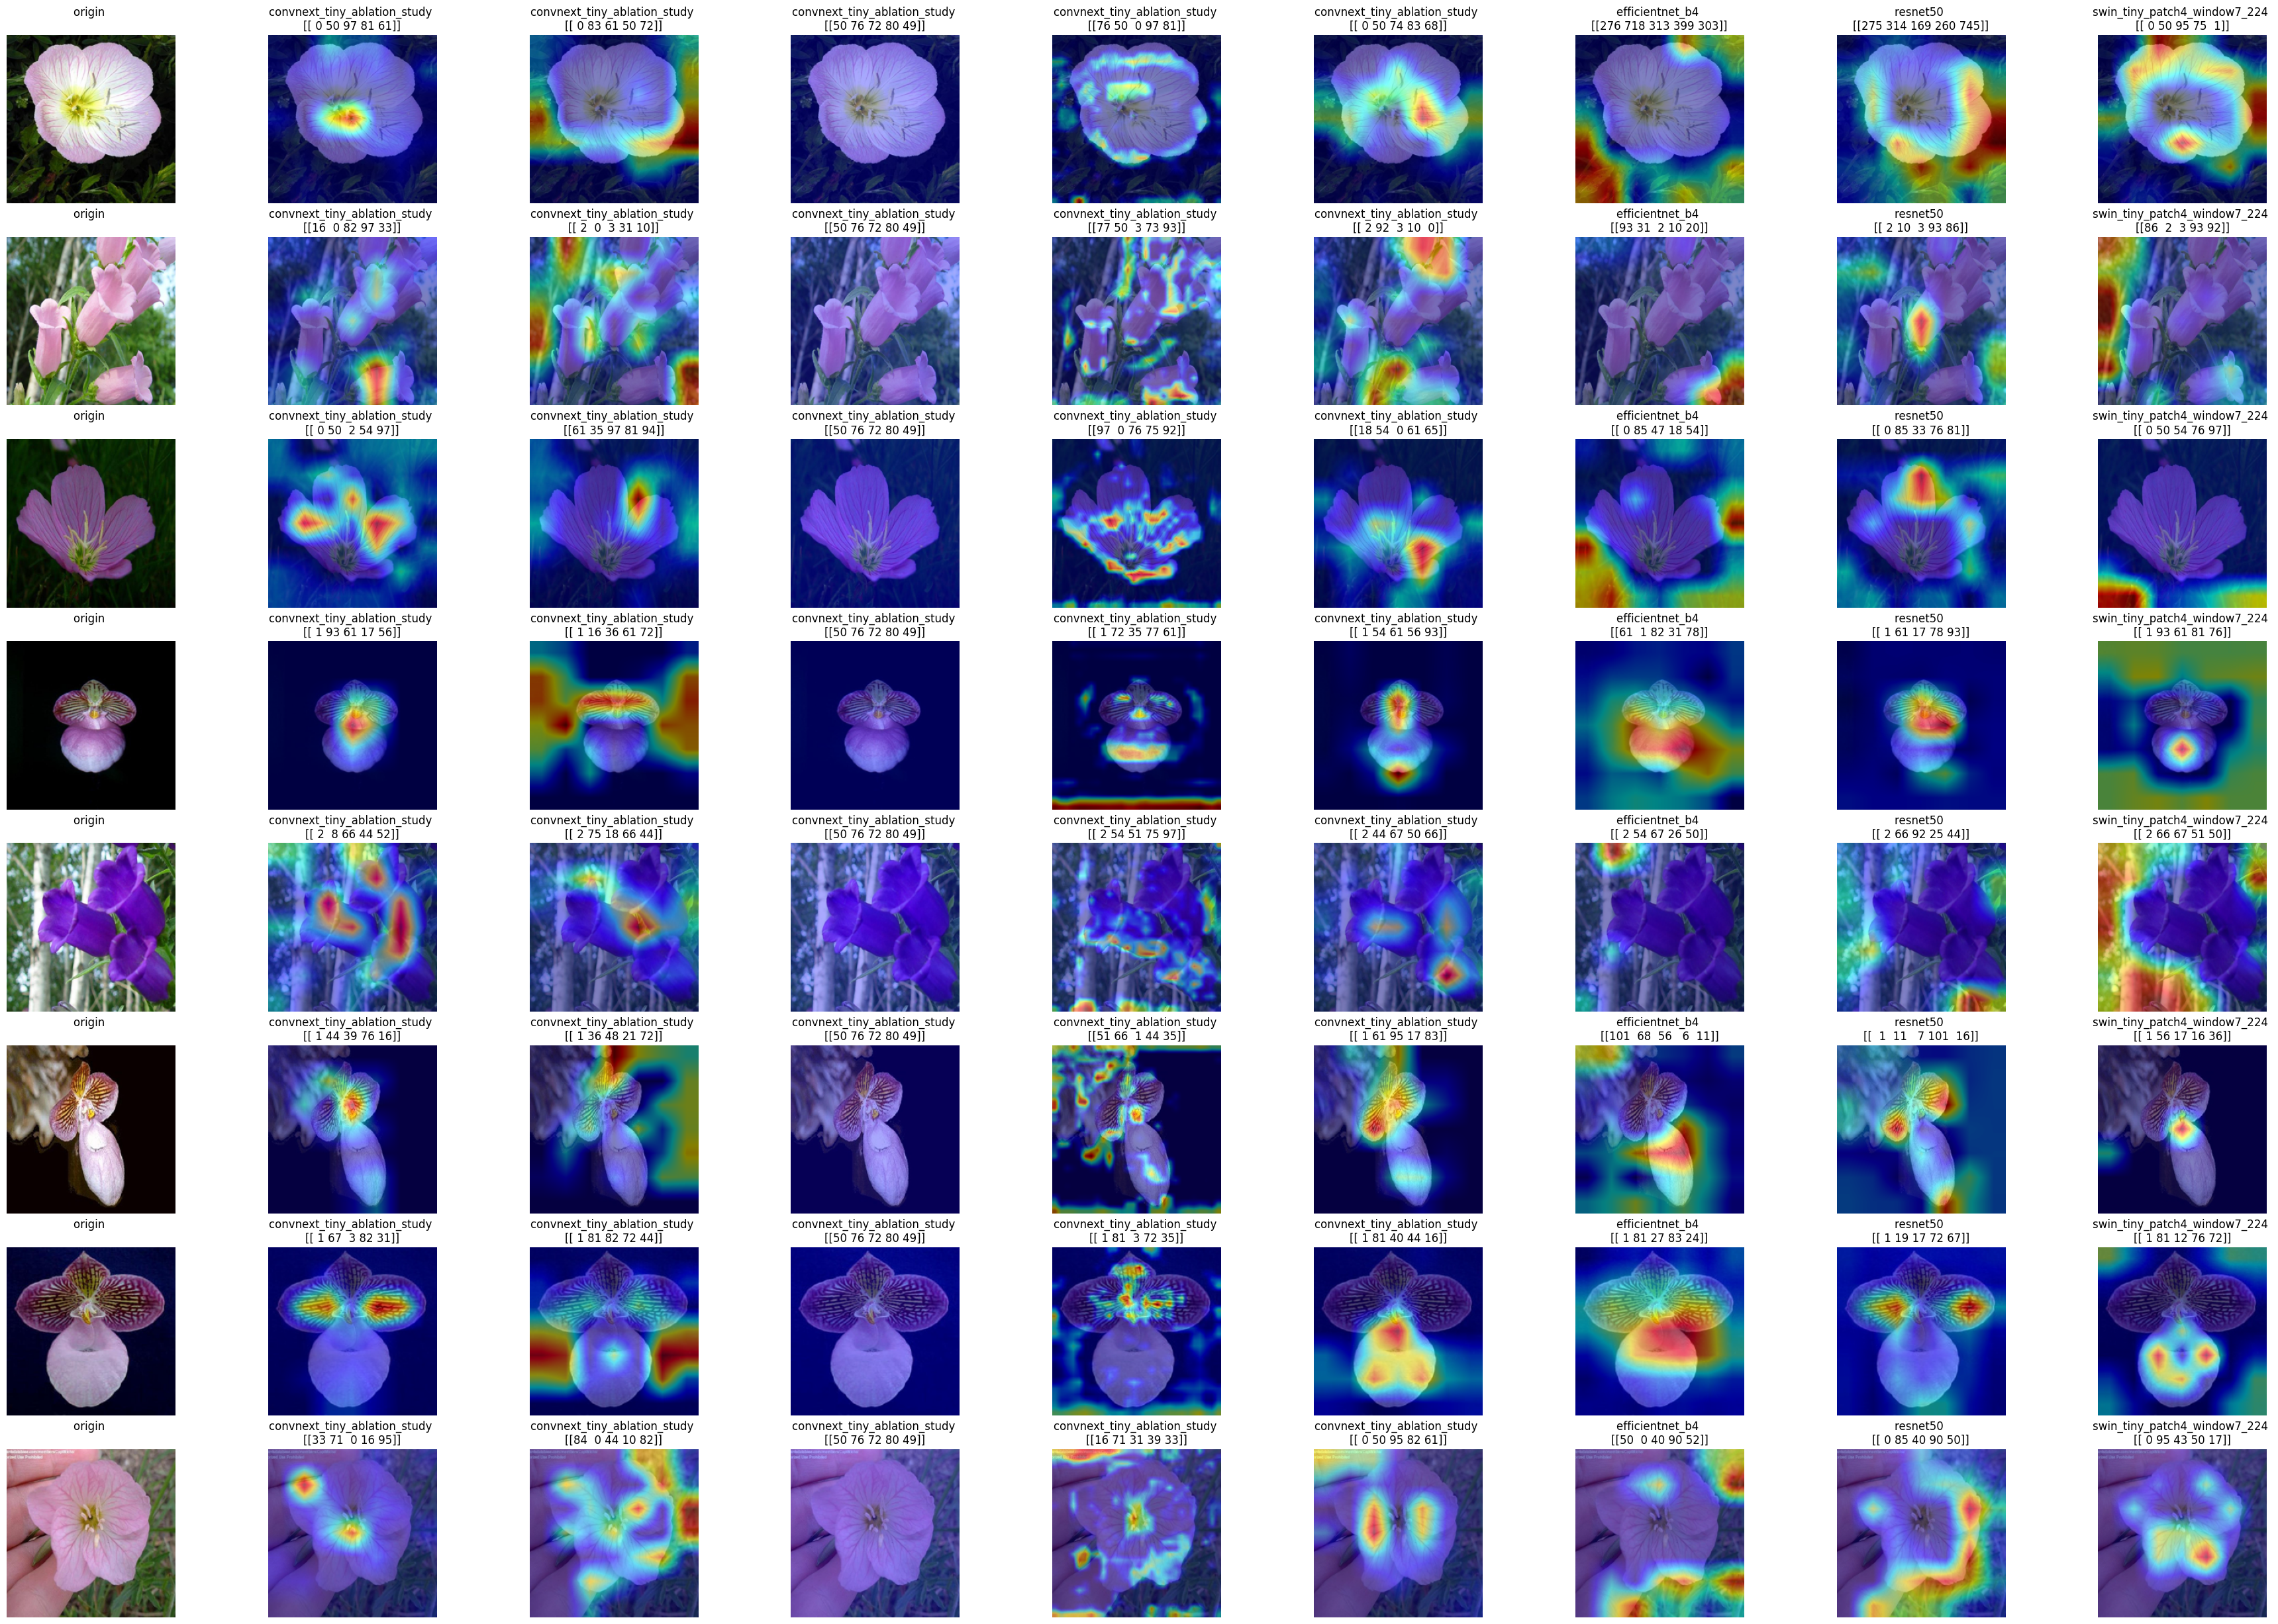

In [176]:
import matplotlib.pyplot as plt
plt.figure(figsize=(45,35))
columns = 9
for i, ele in enumerate(rs):
    plt.subplot(len(rs) // columns + 1, columns, i + 1)
    plt.title('{} \n{}'.format(ele['name'],ele['top5']))
    plt.axis('off')
    plt.imshow(ele['gradcam'])